In [17]:
from astropy.io import fits

# Nom du fichier fits - Il s'agit d'une brute de 300s prise avec une caméra ATIK 314L+
#fitsImage = '../IC_3355_Light_Luminance_300_secs_011.fits'
fitsImage = 'NGC_4567_Light_Luminance_120_secs_007_c-WCS.fit'
# On lit l'ensemble des HDU (Header Data Units) stockés dans le fichier fits
hduList = fits.open(fitsImage)

In [18]:
hduList.info()

Filename: NGC_4567_Light_Luminance_120_secs_007_c-WCS.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     470   (1382, 1039)   float32   


Ici le fichier fits est très simple, il contient un seul HDU (primary HDU)  
Celui est lui même composé de:
- un en-tête avec 50 mots clés
- une image de 1391x1039 pixels
Les valeurs correspondant à chaque pixel sont codées sur 16 bits

In [19]:
# On affiche le contenu de l'en-tête
header = hduList[0].header
header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                 1382 / length of data axis 1                          
NAXIS2  =                 1039 / length of data axis 2                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
PROGRAM = 'PixInsight 1.8.8-5' / Software that created this HDU                 
COMMENT PixInsight Class Library: PCL 2.1.20                                    
COMMENT FITS module version 1.1.6                                               
COLORSPC= 'Grayscale'          / PCL: Color space                               
RESOLUTN=                  7

In [20]:
# on peut lire un mot clé particulier
header['OBJECT']

'NGC_4567'

À noter que l'on peut très facilement modifier la valeur associée à un mot clé donné et la sauvegarder dans un nouveau 
fichier fits

L'image est un simple tableau de valeurs. À chaque pixel correspond un certain nombre d'ADU (je suppose que ADU = Analog to Digital Units). Après pré-traitement le nombre d'ADU sera proportionel au flux lumineux reçu.

In [21]:
# on extrait les données correspondant à l'image
data = hduList[0].data
data

array([[0.03090092, 0.02729231, 0.02710131, ..., 0.03053915, 0.02842453,
        0.02760503],
       [0.02801516, 0.02749892, 0.02881704, ..., 0.02907012, 0.02713967,
        0.03105319],
       [0.02662499, 0.02939246, 0.03072566, ..., 0.03053421, 0.03007523,
        0.03096325],
       ...,
       [0.02966498, 0.02777943, 0.02882982, ..., 0.02680435, 0.02834872,
        0.02875825],
       [0.02813032, 0.02675201, 0.02670957, ..., 0.03182035, 0.02665199,
        0.02702107],
       [0.02833478, 0.02958206, 0.02833172, ..., 0.0278801 , 0.02851461,
        0.02703648]], dtype=float32)

Maintenant on va voir ce qu'on peut faire avec l'image

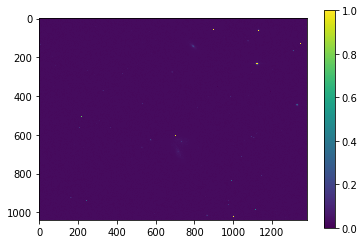

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt

# D'abord on affiche l'image avec une échelle linéaire
plt.imshow(data)
plt.colorbar()

Comme on le constate on ne voit pas grand chose avec une échelle linéaire car la plupart des pixels reçoivent
très peu de lumière, on voit donc essentiellement le fond de ciel avec quelques rares zones brillantes
correspondant aux étoiles et aux coeurs des galaxies

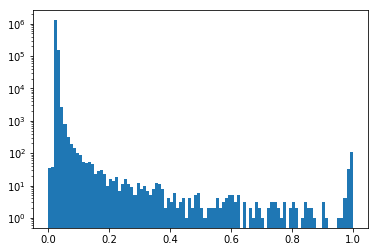

In [23]:
# on visualise l'histogramme des valeurs des pixels en échelle logarithmique
plt.hist(data.ravel(), bins=100)
plt.yscale('log')

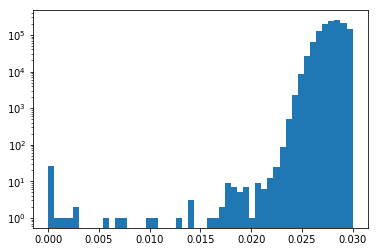

In [24]:
plt.hist(data.ravel(), bins=50, range=[0,0.03])
plt.yscale('log')

On voit donc que les pixels "vivants" débutent à environ 0.02

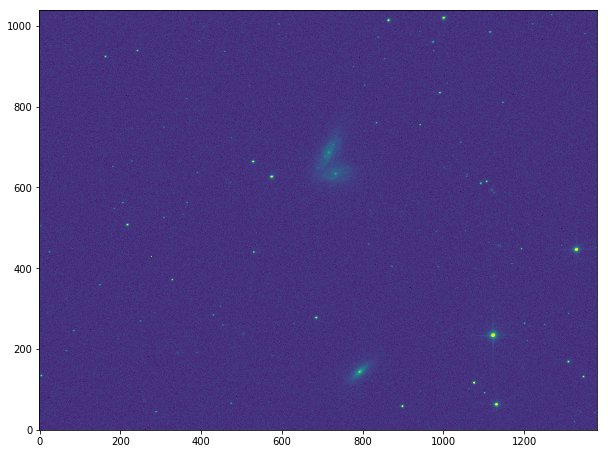

In [25]:
from astropy.visualization import AsinhStretch
from astropy.visualization.mpl_normalize import ImageNormalize

# on va normaliser notre image en utilisant une courbe de réponse non linéaire (asinh)
# et on en profite pour éliminer la contribution des pixels morts

vMin = 0.02
vMax = 1
st = 0.01      # c'est un paramètre qui fixe la forme de la réponse asinh
plt.figure(figsize=(10,10))
norm = ImageNormalize(vmin=vMin, vmax=vMax, stretch=AsinhStretch(st))
plt.imshow(data, origin='lower', norm=norm)

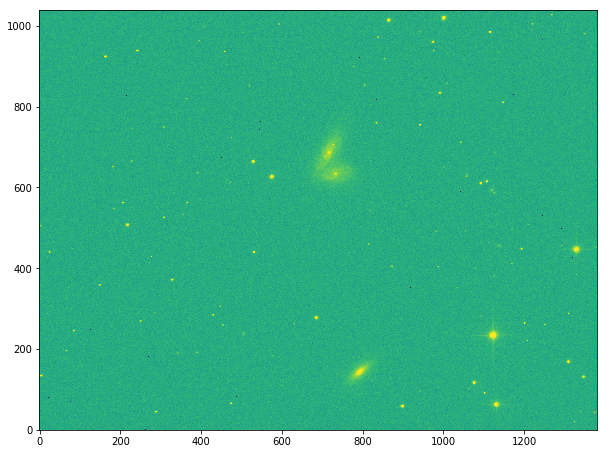

In [26]:
# on resserre un peu l'histogramme et on augmente le paramètre de stretch
vMin = 0.02
vMax = 0.1
st = 0.005
norm = ImageNormalize(vmin=vMin, vmax=vMax, stretch=AsinhStretch(st))
plt.figure(figsize=(10,10))
plt.imshow(data, origin='lower', norm=norm)

In [27]:
from astropy.stats import sigma_clipped_stats

mean, median, std = sigma_clipped_stats(data, sigma=3.0)  
print((mean, median, std))

(0.028299725, 0.028285652, 0.0013042155)


In [28]:
from photutils import DAOStarFinder
daofind = DAOStarFinder(fwhm=3.0, threshold=5.*std)
sources = daofind(data - median)
for col in sources.colnames:
    sources[col].info.format = '%.8g'  # for consistent table output
print(sources)

 id xcentroid ycentroid  sharpness  ... sky     peak        flux       mag     
--- --------- ---------- ---------- ... --- ------------ --------- ------------
  1 1334.2229 0.10422894 0.83805781 ...   0  0.013964664 1.5698222  -0.48962616
  2 967.58168  6.6600467 0.64584797 ...   0  0.010042995 1.2822115  -0.26989919
  3 1325.6911  20.406976 0.57184345 ...   0  0.062505759 8.7399101   -2.3537674
  4 1375.7945  42.190231 0.65549425 ...   0    0.1155203 15.110531   -2.9481993
  5 289.62435  45.057038 0.63283922 ...   0    0.2966986 38.280681   -3.9574491
  6 1341.3894  44.897964 0.53127153 ...   0  0.014068712 1.6991807  -0.57559892
  7 107.96735  46.084922  0.7122757 ...   0  0.026416428  3.321587   -1.3033641
  8 899.29183  58.484502 0.32872641 ...   0   0.97012067 121.65661   -5.2128393
  9 1129.4104  62.795734 0.53781738 ...   0   0.97171438 89.102445   -4.8747241
 10 1132.7691  62.985287 0.34646027 ...   0   0.97171438 67.069668   -4.5663154
...       ...        ...        ... ... 

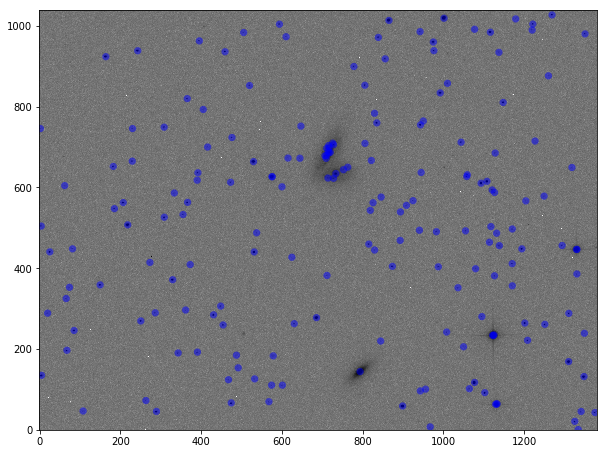

In [29]:
import numpy as np
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils import CircularAperture

positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(positions, r=4.)
#norm = ImageNormalize(stretch=SqrtStretch())

plt.figure(figsize=(10,10))

plt.imshow(data, cmap='Greys', origin='lower', norm=norm)
apertures.plot(color='blue',lw=4, alpha=0.5)

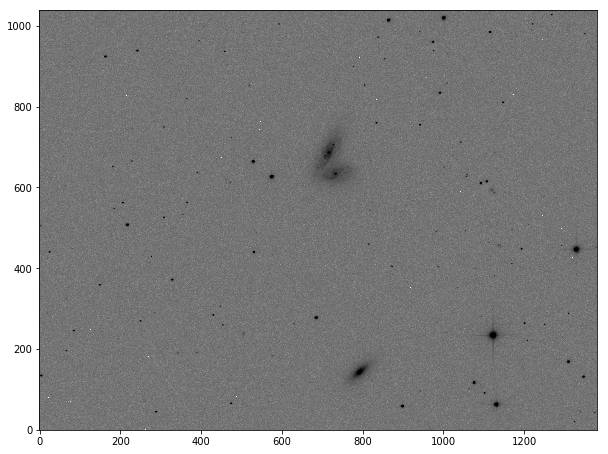

In [30]:
plt.figure(figsize=(10,10))
plt.imshow(data, cmap='Greys', origin='lower', norm=norm)

In [31]:
import psfex